## Yolo v1 - v3
### Reference
Joseph Redmon, et al., You Only Look Once: Uniﬁed, Real-Time Object Detection, 2016. [link](https://arxiv.org/abs/1506.02640)
### Contents
* Proposed basic neural network inspired by GoogLeNet
* Architecture of baseline Yolo-v1
  * <img src='../etc/images/Yolo-1.png' width=300>
* Loss function
  * <img src='../etc/images/Yolo-2.png' width=300>
### Keys
* center_x, center_y, width, height, confidence 가 추가되어 학습 진행


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from torchinfo import summary

import pandas as pd
import numpy as np

from collections import Counter
import cv2
from PIL import Image
import random

from tqdm.notebook import tqdm_notebook

import sys
sys.path.append('..')

from python_scripts import data_setup
from python_scripts.Yolo_v3 import engine, utils

In [2]:
class_names = {
    0: 'Water buffalo',
    1: 'Elephant',
    2: 'Rhinoceros',
    3: 'Zebra'
}

In [3]:
train_data = pd.read_csv('../data/Animal Detection/train/train_output.csv')
train_data.head(10)

,filename,label
0,1,1 0.438281 0.529551 0.814063 0.704492
1,2,3 0.541016 0.524324 0.849219 0.672973
2,3,2 0.492500 0.517045 0.695000 0.725000
3,4,2 0.585156 0.525000 0.692187 0.785135
4,5,3 0.385547 0.645270 0.614844 0.698649\n3 0.559...
5,6,1 0.429688 0.596737 0.590625 0.778555
6,7,3 0.516797 0.504054 0.380469 0.929730
7,8,0 0.476526 0.520833 0.298122 0.404167
8,9,2 0.461184 0.470783 0.435774 0.877711\n2 0.813...
9,10,3 0.700781 0.626042 0.532813 0.739583


In [4]:
test_data = pd.read_csv('../data/Animal Detection/test/test_output.csv')
test_data.head()

,filename,label
0,1205,1 0.662500 0.482394 0.606250 0.607981\n1 0.207...
1,1206,3 0.703906 0.629977 0.367188 0.707260\n3 0.331...
2,1207,2 0.511250 0.540338 0.832500 0.615385
3,1208,0 0.551562 0.545946 0.484375 0.494595
4,1209,3 0.429000 0.564000 0.702000 0.749333\n3 0.402...


### Yolo v1 darknet architecture

In [5]:
class basic_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.LeakyReLU(0.1, inplace=False)

    def forward(self, X):
        X = self.conv(X)
        X = self.bn(X)
        X = self.activation(X)
        return X

In [6]:
class reduction_conv(nn.Module):
  def __init__(self, in_channels, reduction_channels, out_channels, kernel_size=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.reduction = nn.Conv2d(
      in_channels=in_channels,
      out_channels=reduction_channels,
      kernel_size=1,
      bias=False
    )
    self.expansion = basic_conv(
      in_channels=reduction_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      padding='same',
    )

  def forward(self, X):
    X = self.reduction(X)
    X = self.expansion(X)
    return X

In [7]:
class Yolo_darknet_v1_conv(nn.Module):
  def __init__(self, num_boxes, num_classes, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.adaptive_pool = nn.AdaptiveAvgPool2d(448)
    self.conv_seq_1 = nn.Sequential(
      basic_conv(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_2 = nn.Sequential(
      basic_conv(
        in_channels=64,
        out_channels=192,
        kernel_size=3,
        padding=1,
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_3 = nn.Sequential(
      reduction_conv(
        in_channels=192,
        reduction_channels=128,
        out_channels=256,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=256,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_4 = nn.Sequential(
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_5 = nn.Sequential(
      reduction_conv(
        in_channels=1024,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=1024,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        stride=2,
        padding=1,
      )
    )
    self.conv_seq_6 = nn.Sequential(
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      )
    )
    self.conn_layer = nn.Sequential(
      basic_conv(
        in_channels=1024,
        out_channels=4096,
        kernel_size=1
      ),
      nn.Conv2d(
        in_channels=4096,
        out_channels=(5*num_boxes + num_classes),
        kernel_size=1
      )
    )

  def forward(self, X):
    X = self.adaptive_pool(X)
    X = self.conv_seq_1(X)
    X = self.conv_seq_2(X)
    X = self.conv_seq_3(X)
    X = self.conv_seq_4(X)
    X = self.conv_seq_5(X)
    X = self.conv_seq_6(X)
    X = self.conn_layer(X)
    return X

In [8]:
model = Yolo_darknet_v1_conv(num_boxes=3, num_classes=4)
model(torch.randn((5, 3, 300, 412))).shape

torch.Size([5, 19, 7, 7])

In [9]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Yolo_darknet_v1_conv                     --
├─AdaptiveAvgPool2d: 1-1                 --
├─Sequential: 1-2                        --
│    └─basic_conv: 2-1                   --
│    │    └─Conv2d: 3-1                  9,408
│    │    └─BatchNorm2d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-3                        --
│    └─basic_conv: 2-3                   --
│    │    └─Conv2d: 3-4                  110,592
│    │    └─BatchNorm2d: 3-5             384
│    │    └─LeakyReLU: 3-6               --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-4                        --
│    └─reduction_conv: 2-5               --
│    │    └─Conv2d: 3-7                  24,576
│    │    └─basic_conv: 3-8              295,424
│    └─reduction_conv: 2-6               --
│    │    └─Conv2d: 3-9                  65,536
│    │    └─basic_conv: 3-10             1,180,6

## YoloV1 model for training animal-detection datasets
* number of parameters: 64,443,603

In [10]:
class dataset(Dataset):
    def __init__(self, data, path, transforms, image_size, augment=False, multiscale=False) -> None:
        super().__init__()
        self.path = path
        self.data = data
        self.transforms = transforms
        self.image_size = image_size
        self.augment = augment
        self.multiscale = multiscale
        self.batch_count = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # return (image_path, image(numpy), label(list))
        image_path = self.path + ('000' + str(self.data['filename'][index]))[-4:] + '.jpg'

        if self.augment:
            image = self.transforms(Image.open(image_path).convert('RGB'))
        else:
            image = transforms.ToTensor()(Image.open(image_path).convert('RGB'))
        _, h, w = image.shape

        image, pad = utils.pad_to_square(image)
        _, h_padded, w_padded = image.shape

        label = [[float(s) for s in obj.split(' ')] for obj in self.data['label'][index].split('\n')]
        for l in label:
            l[1] = ((l[1] * w) + pad[0]) / w_padded
            l[2] = ((l[2] * h) + pad[1]) / h_padded
            l[3] *= w / w_padded
            l[4] *= h / h_padded

        return image_path, image, torch.tensor(label)

    def collate_fn(self, batch):
        paths, images, targets = list(zip(*batch))

        images = [image for image in images]
        targets = [target for target in targets]

        if self.augment:
            for i in range(len(images)):
                if random.random() <= 0.5:
                    images[i], targets[i] = utils.horizontal_flip(images[i], targets[i])
                if random.random() <= 0.5:
                    images[i], targets[i] = utils.x_transition(images[i], targets[i])
                if random.random() <= 0.5:
                    images[i], targets[i] = utils.y_transition(images[i], targets[i])

        if self.multiscale and self.batch_count % 10 == 0:
            self.image_size = random.choice(range(320, 608 + 1, 32))

        images = torch.stack([utils.resize(image, self.image_size) for image in images])
        self.batch_count += 1

        return paths, images, targets


In [11]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=1.5, saturation=1.5, hue=0.1),
    transforms.ToTensor()
])

In [12]:
train_dataset = dataset(
    data=train_data,
    path='../data/Animal Detection/train/',
    transforms=train_transforms,
    image_size=448,
    augment=True,
    multiscale=False
)
train_dataset[0]

('../data/Animal Detection/train/0001.jpg',
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[1.0000, 0.4383, 0.5196, 0.8141, 0.4664]]))

In [13]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=train_dataset.collate_fn
)

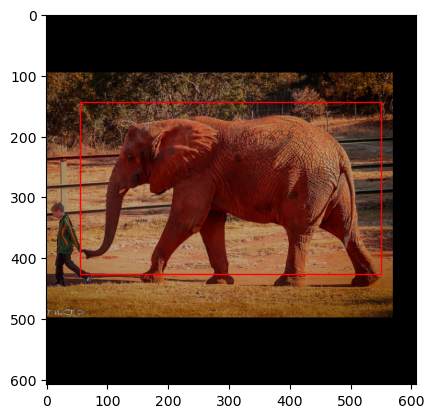

In [14]:
# 정답 박스 시각화 모듈

_, x_test, y_test = next(iter(train_dataloader))

import matplotlib.pyplot as plt
import matplotlib.patches as pts
fig, ax = plt.subplots()
ax.imshow(x_test[0].permute(1, 2, 0))
_, w, h = x_test[0].shape
count = 0
for o in y_test[0]:
    ax.add_patch(
        pts.Rectangle(
            ((o[1] - o[3]/2) * w, (o[2] - o[4]/2) * h),
            o[3] * w,
            o[4] * h,
            edgecolor='red',
            facecolor=(1,0,0,0)
        )
    )
    count += 1
    if count > 100:
        break

In [15]:
train_sub_dataset, val_sub_dataset = data_setup.split_dataset(
    train_dataset,
    0.8
)

[INFO] Splitting dataset of length 1204 into splits of size: 963 and 241


In [16]:
test_transforms = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = dataset(
    data=test_data,
    path='../data/Animal Detection/test/',
    transforms=test_transforms,
    image_size=448
)

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [18]:
learning_rate_list = [1e-4]
weight_decay_list = [1e-4]
epochs_list = [20]
batch_size_list = [16]

In [19]:
loss_fn = utils.Yolo_loss(4)
pre_score_fn = utils.pre_score_fn_Yolo(4, use_nms=False)
ap_func = utils.average_precision(0.75)
score_fn = utils.score_fn_Yolo(ap_func)

In [20]:
result = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='Yolo_v1_animal-detection',
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    class_names=[0, 1, 2, 3],
    loss_fn=loss_fn,
    pre_score_fn=pre_score_fn,
    score_fn=score_fn,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=False,
    device=device,
    gradient_accumulation_num=1,
    saving_max=True,
    metric_learning=False,
)

Yolo_v1_animal-detection_LR_0.0001_WD_0.0001_BS_16_GA_1:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/76 [00:00<?, ?it/s]

RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes.

In [106]:
model.load_state_dict(torch.load('../models/Yolo_v1_animal-detection_LR_0.001_WD_0.0001_BS_16_GA_1_EPOCH_6_TEST-ACC_0.1502.pth'))

<All keys matched successfully>

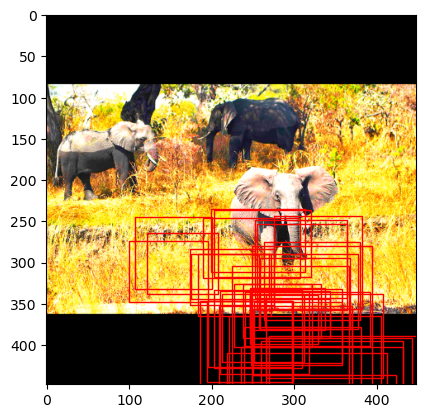

In [107]:
# 생성된 모든 박스 시각화 모듈

_, x_test, _ = train_dataset[12]

# train 되지 않은 모델 확인 시
# model1 = Yolo_conv(3, 4)
# y_test = model1(x_test.unsqueeze(0))[:, 4:].permute(0, 2, 3, 1).reshape(-1, 5)

# train 된 모델 확인 시
x_test = utils.resize(x_test, 448)
y_test = model(x_test.unsqueeze(0).to(device))[:, 4:].permute(0, 2, 3, 1).reshape(-1, 5)

# 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as pts
fig, ax = plt.subplots()
ax.imshow(x_test.permute(1, 2, 0))
_, w, h = x_test.shape
count = 0
for o in y_test.detach().cpu():
    ax.add_patch(
        pts.Rectangle(
            ((o[1] - o[3]/2) * w, (o[2] - o[4]/2) * h),
            o[3] * w,
            o[4] * h,
            edgecolor='red',
            facecolor=(1,0,0,0)
        )
    )
    count += 1
    if count > 50:
        break

In [108]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=test_dataset.collate_fn
)

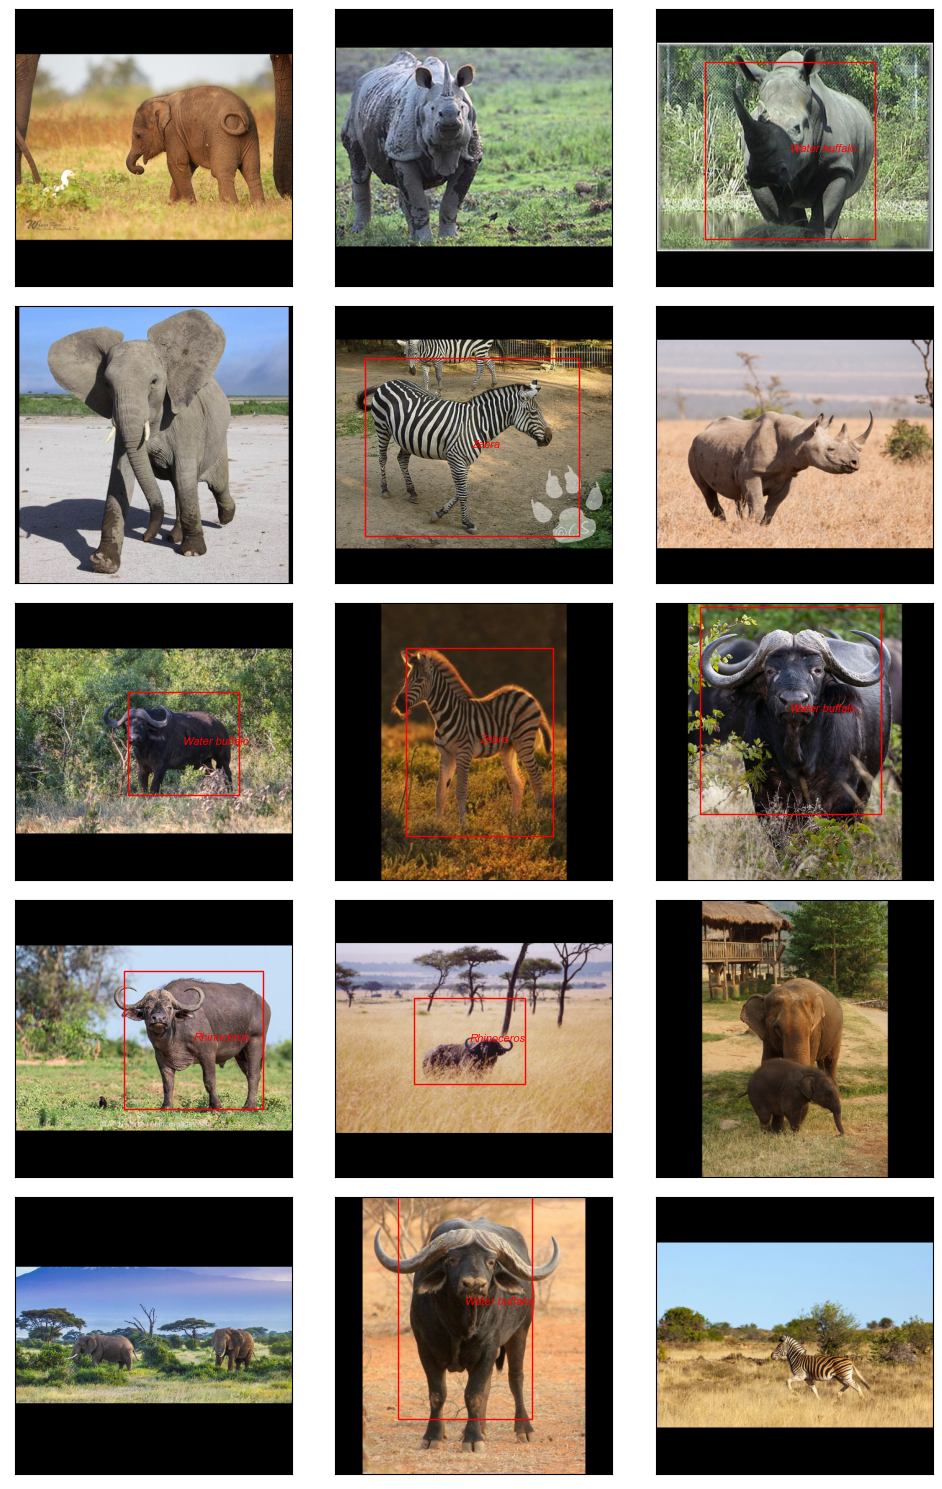

In [109]:
# 추려진 주요 박스 시각화 모듈

num_classes = 4
pre_score_fn = utils.pre_score_fn_Yolo(num_classes, use_nms=True)

# 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as pts

fig, ax = plt.subplots(5, 3, figsize=(10, 15))
font = {'family': 'Arial',
      'color':  'red',
      'style': 'italic',
      'size': 8}

model.eval()
model.to(device)
with torch.inference_mode():
    for i in range(15):
        _, x_test, _ = test_dataset[random.randint(0, 299)]
        x_test = utils.resize(x_test, 448)
        y_test = model(x_test.unsqueeze(0).to(device))
        y_pred = pre_score_fn(y_test.cpu(), prob_th=0.0, conf_th=0.5, nms_th=0.5)

        ax[i // 3][i % 3].imshow(x_test.permute(1, 2, 0))
        ax[i // 3][i % 3].set_xticks([])
        ax[i // 3][i % 3].set_yticks([])
        _, w, h = x_test.shape
        count = 0
        for c in range(len(y_pred[0])):
            for o in y_pred[0][c]:
                o = o.detach().numpy()
                ax[i // 3][i % 3].add_patch(
                    pts.Rectangle(
                        ((o[1] - o[3]/2) * w, (o[2] - o[4]/2) * h),
                        o[3] * w,
                        o[4] * h,
                        edgecolor='red',
                        facecolor=(1,0,0,0)
                    )
                )
                ax[i // 3][i % 3].text(o[1] * w, o[2] * h, class_names[c], fontdict=font)

                count += 1
                if count > 150:
                    break
fig.tight_layout()

In [110]:
# model validation module

num_classes = 4
model.eval()
model.to(device)
pre_score_fn = utils.pre_score_fn_Yolo(num_classes, use_nms=True)
average_precision_fn = utils.average_precision(0.75)
test_preds_checked = {}
num_target = Counter([])
with torch.inference_mode():
    for _, X_batch_test, y_batch_test in tqdm_notebook(test_dataloader):
        test_output = model(X_batch_test.to(device))
        test_pred = pre_score_fn(test_output.cpu(), prob_th=0.0, conf_th=0.5, nms_th=0.4)

        for i in range(len(test_pred)):
            test_pred_checked = average_precision_fn(test_pred[i], y_batch_test[i])
            for key in test_pred_checked.keys():
                if key in test_preds_checked:
                    test_preds_checked[key].extend(test_pred_checked[key])
                else:
                    test_preds_checked[key] = test_pred_checked[key]

            num_target += Counter([t[0].item() for t in y_batch_test[i]])

mAP = utils.mean_average_precision(test_preds_checked, num_target)

print(mAP)


  0%|          | 0/19 [00:00<?, ?it/s]

0.4420113056476693


In [24]:
a = torch.tensor([0.4978, 0.4829, 0.4542, 0.4242, 0.3954, 0.3945, 0.3937, 0.3828, 0.3820, 0.3782, 0.3782, 0.3723, 0.3525, 0.3459, 0.3372, 0.3345, 0.3312, 0.3287, 0.3273, 0.3253, 0.3244, 0.3209, 0.3178, 0.3117, 0.3103, 0.3080, 0.3052, 0.3013, 0.2957, 0.2919, 0.2842, 0.2744, 0.2668, 0.2660, 0.2431, 0.2398, 0.2309, 0.2274, 0.2235, 0.2218, 0.2195, 0.2105, 0.2087, 0.2067, 0.2062, 0.1989, 0.1980, 0.1923, 0.1901, 0.1820, 0.1800, 0.1762, 0.1677, 0.1619, 0.1566, 0.1474, 0.1435, 0.1394, 0.1377, 0.1344, 0.1339, 0.1310, 0.1290, 0.1281, 0.1247, 0.1218, 0.1209, 0.1186, 0.1150, 0.1092, 0.1022, 0.1016, 0.1005])
b = [False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
pred_checked = {1: list(zip(a, b))}
num_target_by_classes = 178